# 4.2b - Compare all pairs of classes. How easy is to distinguish between them?

In [1]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.2b-pairs'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

# Create models

In [4]:
cats = rawset.categories
tsets, vsets = rawset.rnd_split_fraction_by_category(0.5)
tsets = tsets.by_category()
vsets = vsets.by_category()
r = report.Reporter2(result_dir + '/creation.tsv')
for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        print(cats[i], cats[j])
        mycats = [cats[i], cats[j]]
        myset = rawset.filter(lambda x: rawset.category_from(x) in mycats)
        myset.rebuild_categories()
        tset, vset = myset.rnd_split_fraction_by_category(0.5)

        model = models.C256_16_16_L128_D(
            2, 256, 'softmax', 'categorical_crossentropy')
        result = Trainer(
            model,
            xs_encoder='one_hot',
            batch_size=100,
            steps_per_epoch=2,
            validation_steps=2*2,
            patience=10,
        ).train(tset, vset)
        h5_path = os.path.join(result_dir, '%s_%s.h5' % (cats[i], cats[j]))
        model.save(h5_path)
        print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])
        r.line(cat1=cats[i],
               cat2=cats[j],
               elapsed=result.elapsed,
               **report.report_epochs(**result._asdict()),
               **report.report_metrics(**result._asdict()),
              )
r.close()

csv dbase3
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
49.020206689834595 0.985
csv doc
91.38898348808289 0.9875
csv dwf
50.52567148208618 1.0
csv eps
54.84157943725586 0.99
csv f
61.17386555671692 0.9725
csv gif
36.78650522232056 1.0
csv gz
56.791020154953 1.0
csv hlp
37.915151834487915 0.9825
csv html
74.33457565307617 0.99
csv java
48.03701424598694 0.97
csv jpg
67.04428386688232 0.995
csv kml
67.21235609054565 0.975
csv kmz
48.11370587348938 0.9975
csv log
86.67183899879456 0.9775
csv pdf
97.96964693069458 0.9875
csv png
56.10292649269104 1.0
csv pps
126.2889084815979 0.9875
csv ppt
86.51726913452148 0.985
csv pptx
101.39157462120056 0.995
csv ps
62.385940074920654 0.97
csv rtf
73.4726493358612 0.99
csv sql
81.58186364173889 0.97
csv swf
61.361820936203 1.0
csv txt
65.32014799118042 0.92
csv wp
68.57729506492615 0.98

171.21845364570618 1.0
java pps
187.93175220489502 0.99
java ppt
156.2503626346588 0.9725
java pptx
201.8560745716095 0.995
java ps
187.09311652183533 0.98
java rtf
195.63816261291504 0.98
java sql
173.84330916404724 0.9475
java swf
167.51178765296936 1.0
java txt
162.48389744758606 0.94
java wp
178.82297372817993 0.9875
java xls
153.82061409950256 0.95
java xml
181.09907174110413 0.945
jpg kml
149.81922388076782 0.9925
jpg kmz
200.53669333457947 0.7725
jpg log
163.24233293533325 0.9825
jpg pdf
203.88946986198425 0.765
jpg png
175.82174921035767 0.795
jpg pps
209.98351430892944 0.6825
jpg ppt
212.9909029006958 0.72
jpg pptx
204.57572674751282 0.67
jpg ps
188.56268286705017 0.9925
jpg rtf
202.80007934570312 0.9925
jpg sql
183.0108950138092 0.99
jpg swf
173.7583179473877 0.665
jpg txt
163.4993553161621 0.9925
jpg wp
168.57668805122375 0.98
jpg xls
179.0735354423523 0.975
jpg xml
160.6953673362732 0.995
kml kmz
172.46294283866882 0.985
kml log
168.40733075141907 0.92
kml pdf
171.350391626

# Load results

In [5]:
data = pd.read_csv(result_dir + '/creation.tsv', sep='\t')
data

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,csv,dbase3,49.020207,23,0.9850,0.9850
1,csv,doc,91.388983,33,0.9875,0.9875
2,csv,dwf,50.525671,19,1.0000,1.0000
3,csv,eps,54.841579,19,0.9900,0.9900
4,csv,f,61.173866,27,0.9725,0.9725
...,...,...,...,...,...,...
373,txt,xls,263.704780,35,0.9550,0.9550
374,txt,xml,243.222028,21,0.9375,0.9375
375,wp,xls,270.019758,39,0.9350,0.9350
376,wp,xml,242.701594,20,0.9025,0.9025


In [6]:
data = data.sort_values(['val_categorical_accuracy'])
data[data['val_categorical_accuracy'] < 0.7]

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
176,gz,png,135.189132,17,0.5225,0.5225
323,pps,ppt,200.904899,12,0.5375,0.5375
324,pps,pptx,209.195787,14,0.5500,0.5500
345,pptx,swf,218.264685,14,0.5625,0.5625
93,dwf,pptx,101.062404,17,0.5675,0.5675
312,png,pps,193.924627,14,0.5725,0.5725
81,dwf,gz,65.512420,15,0.5775,0.5775
318,png,swf,224.280311,34,0.6000,0.6000
179,gz,pptx,187.366762,29,0.6100,0.6100
328,pps,swf,211.486592,20,0.6125,0.6125


In [7]:
data2 = data.apply(
    lambda x: pd.Series(
        [
            rawset.cat_to_ix[x.cat1],
            rawset.cat_to_ix[x.cat2], 
            x.val_categorical_accuracy
        ], index=['cat1', 'cat2', 'val_acc'])
    , axis=1)
data2

,cat1,cat2,val_acc
176,7.0,16.0,0.5225
323,17.0,18.0,0.5375
324,17.0,19.0,0.5500
345,19.0,23.0,0.5625
93,3.0,19.0,0.5675
...,...,...,...
170,7.0,10.0,1.0000
22,0.0,23.0,1.0000
295,14.0,23.0,1.0000
264,12.0,19.0,1.0000


In [8]:
cat_acc = {}
for i, d in data.iterrows():
    cat1 = d['cat1']
    cat2 = d['cat2']
    cat_acc[cat1] = cat_acc.get(cat1, list())
    cat_acc[cat2] = cat_acc.get(cat2, list())
    cat_acc[cat1].append(d['val_categorical_accuracy'])
    cat_acc[cat2].append(d['val_categorical_accuracy'])    

No handles with labels found to put in legend.


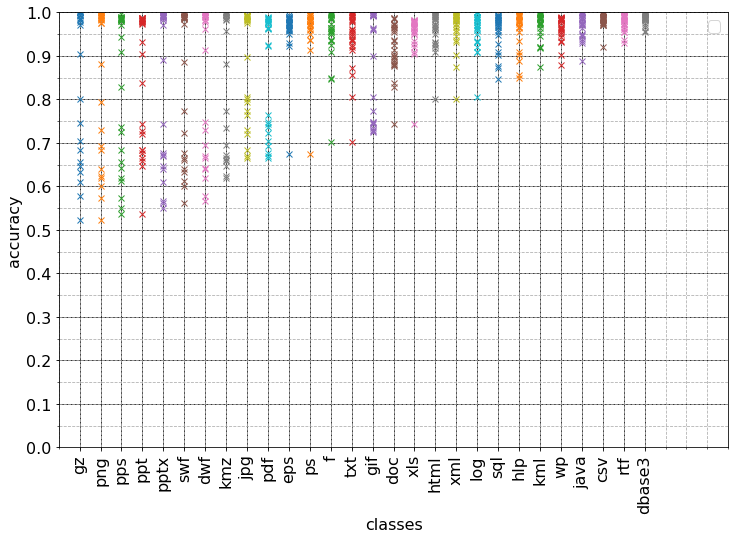

In [9]:
from matplotlib.ticker import MultipleLocator
loc='upper right'
fig = plt.figure(figsize=(12,8))
for k, v in cat_acc.items():
    plt.plot(*zip(*[(k, x) for x in v]), 'x')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('classes', fontsize=16)
plt.xlim((-1, 31))
plt.ylim((-0, 1))
ax1 = plt.gca()
# ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(linestyle='-', color='k', which='major')
plt.grid(linestyle='--', which='minor')
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.legend(loc=loc, prop={'size': 16})
plt.xticks(rotation=90)
#     plt.savefig('acc.png')
plt.show()    

In [10]:
data.min()

cat1                            csv
cat2                         dbase3
elapsed                     36.7865
Epochs                           11
val_binary_accuracy          0.5225
val_categorical_accuracy     0.5225
dtype: object

In [11]:
with open(result_dir + '/nclasses.tsv', 'w') as f:
    f.write('n\tcats\tval_categorical_accuracy\n')
    for i, x in data.iterrows():
        s = '2\t{}\t{}\n'.format(x.cat1+','+x.cat2,x.val_categorical_accuracy)
        f.write(s)

# Add pairs of classes to graph 4.2a

In [30]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right', alpha_on=None):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels is None:
        labels = [None for x in xs]
    for x, y, label, mark in zip(xs, ys, labels, ['bx', 'g-', 'r*', '.mD']):
        plt.plot(x[x==alpha_on], y[x==alpha_on], mark, alpha=0.1, label='')
        plt.plot(x[x!=alpha_on], y[x!=alpha_on], mark, label=label)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')

In [31]:
data42a = pd.read_csv('results/4.2a-nclasses/nclasses.tsv', sep='\t')
data42b = pd.read_csv('results/4.2b-pairs/nclasses.tsv', sep='\t')
mdata = pd.concat([data42a, data42b])

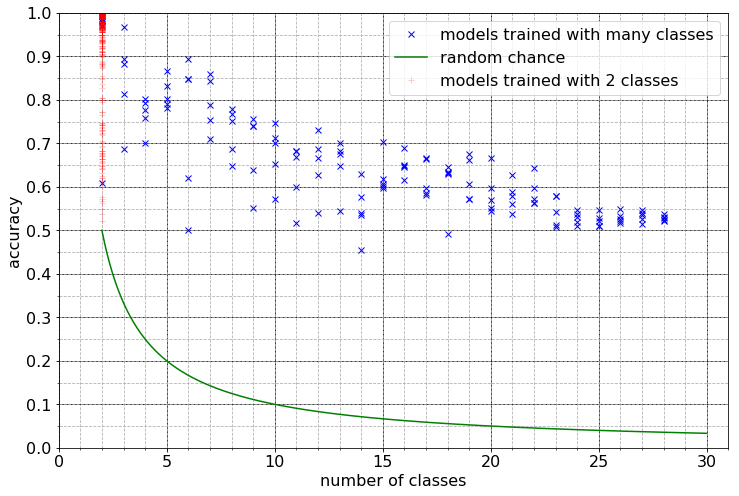

In [35]:
x = np.arange(2,30,0.01)
y = 1/x
plot_acc([data42a['n'], x], [data42a['val_categorical_accuracy'], y], ['models trained with many classes', 'random chance'])
plt.plot(data42b['n'], data42b['val_categorical_accuracy'], 'r+', alpha=0.2, label='models trained with 2 classes')
plt.legend(loc='upper right', prop={'size': 16})

# PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=2)

In [17]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.5000,0.9850,0.9875,1.0000,0.9900,0.9725,1.0000,1.0000,0.9825,0.9900,...,0.9850,0.9950,0.9700,0.9900,0.9700,1.0000,0.9200,0.9875,0.9775,0.9825
1,0.9850,0.5000,0.9875,0.9975,0.9900,0.9575,1.0000,1.0000,0.9900,0.9675,...,0.9875,0.9975,0.9950,0.9900,0.9850,1.0000,0.9550,0.9900,0.9825,0.9850
2,0.9875,0.9875,0.5000,0.9125,0.9675,0.9375,0.9000,0.9050,0.9650,0.9700,...,0.8375,0.8900,0.9725,0.9550,0.8775,0.8850,0.9350,0.8800,0.7425,0.9725
3,1.0000,0.9975,0.9125,0.5000,0.9625,1.0000,0.7475,0.5775,0.9950,0.9975,...,0.6650,0.5675,0.9825,1.0000,0.9925,0.6400,0.9900,0.9825,0.9775,0.9925
4,0.9900,0.9900,0.9675,0.9625,0.5000,0.9600,0.9600,0.9700,0.9775,0.9725,...,0.9775,0.9875,0.6750,0.9300,0.9700,0.9875,0.9500,0.9750,0.9575,0.9825
5,0.9725,0.9575,0.9375,1.0000,0.9600,0.5000,0.9950,0.9950,0.8500,0.9250,...,0.9850,0.9900,0.9375,0.9550,0.8475,0.9975,0.7025,0.9500,0.9650,0.9550
6,1.0000,1.0000,0.9000,0.7475,0.9600,0.9950,0.5000,0.7450,0.9950,0.9975,...,0.7275,0.7425,0.9925,0.9950,0.9950,0.7725,1.0000,0.9625,0.9650,0.9950
7,1.0000,1.0000,0.9050,0.5775,0.9700,0.9950,0.7450,0.5000,1.0000,1.0000,...,0.6825,0.6100,0.9825,0.9950,0.9875,0.6325,0.9950,0.9850,0.9775,1.0000
8,0.9825,0.9900,0.9650,0.9950,0.9775,0.8500,0.9950,1.0000,0.5000,0.9100,...,0.9800,0.9925,0.9800,0.9925,0.9025,0.9925,0.8550,0.9550,0.9675,0.9675
9,0.9900,0.9675,0.9700,0.9975,0.9725,0.9250,0.9975,1.0000,0.9100,0.5000,...,0.9825,0.9925,0.9600,0.9625,0.9675,0.9925,0.9250,0.9675,0.9500,0.8000


In [18]:
data6 = pca.fit_transform(data5)

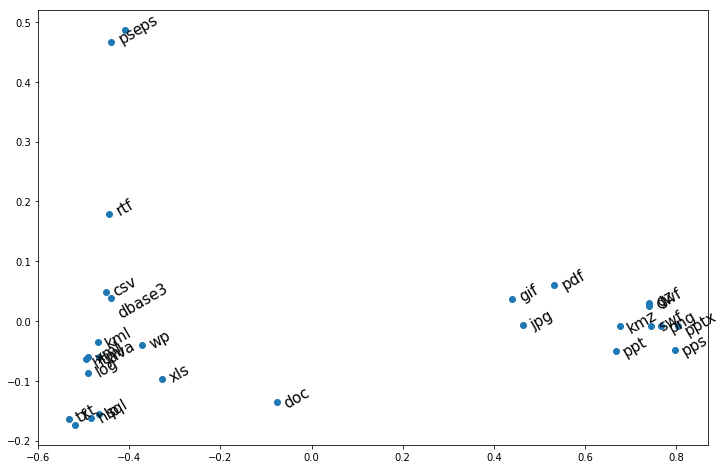

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data6[:,0], data6[:,1], 'o')

for i in range(28):
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.01, data6[i,1]+0.01),fontsize=15)
    t.set_rotation(30)

In [20]:
data6[:,0]>0.4

array([False, False, False,  True, False, False,  True,  True, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True, False, False, False,
       False])

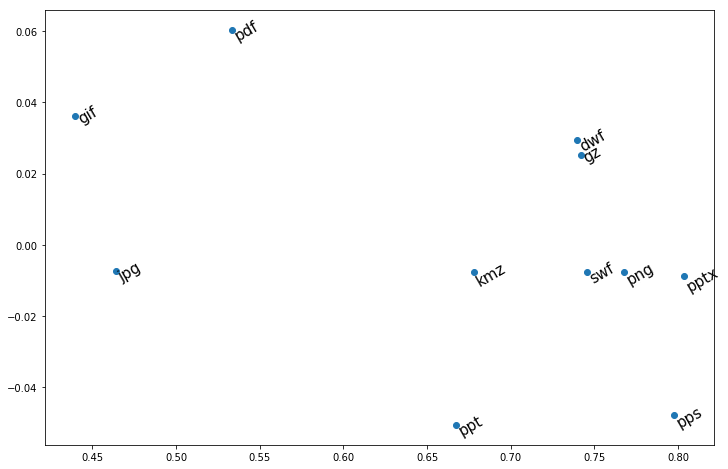

In [21]:
data7 = data6[data6[:,0]>0.4]
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(len(data6)):
    if data6[i,0] < 0.4:
        continue
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.0, data6[i,1]+0.0),fontsize=15)
    t.set_rotation(30)

# Multi-dimensional scaling

In [22]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.5000,0.9850,0.9875,1.0000,0.9900,0.9725,1.0000,1.0000,0.9825,0.9900,...,0.9850,0.9950,0.9700,0.9900,0.9700,1.0000,0.9200,0.9875,0.9775,0.9825
1,0.9850,0.5000,0.9875,0.9975,0.9900,0.9575,1.0000,1.0000,0.9900,0.9675,...,0.9875,0.9975,0.9950,0.9900,0.9850,1.0000,0.9550,0.9900,0.9825,0.9850
2,0.9875,0.9875,0.5000,0.9125,0.9675,0.9375,0.9000,0.9050,0.9650,0.9700,...,0.8375,0.8900,0.9725,0.9550,0.8775,0.8850,0.9350,0.8800,0.7425,0.9725
3,1.0000,0.9975,0.9125,0.5000,0.9625,1.0000,0.7475,0.5775,0.9950,0.9975,...,0.6650,0.5675,0.9825,1.0000,0.9925,0.6400,0.9900,0.9825,0.9775,0.9925
4,0.9900,0.9900,0.9675,0.9625,0.5000,0.9600,0.9600,0.9700,0.9775,0.9725,...,0.9775,0.9875,0.6750,0.9300,0.9700,0.9875,0.9500,0.9750,0.9575,0.9825
5,0.9725,0.9575,0.9375,1.0000,0.9600,0.5000,0.9950,0.9950,0.8500,0.9250,...,0.9850,0.9900,0.9375,0.9550,0.8475,0.9975,0.7025,0.9500,0.9650,0.9550
6,1.0000,1.0000,0.9000,0.7475,0.9600,0.9950,0.5000,0.7450,0.9950,0.9975,...,0.7275,0.7425,0.9925,0.9950,0.9950,0.7725,1.0000,0.9625,0.9650,0.9950
7,1.0000,1.0000,0.9050,0.5775,0.9700,0.9950,0.7450,0.5000,1.0000,1.0000,...,0.6825,0.6100,0.9825,0.9950,0.9875,0.6325,0.9950,0.9850,0.9775,1.0000
8,0.9825,0.9900,0.9650,0.9950,0.9775,0.8500,0.9950,1.0000,0.5000,0.9100,...,0.9800,0.9925,0.9800,0.9925,0.9025,0.9925,0.8550,0.9550,0.9675,0.9675
9,0.9900,0.9675,0.9700,0.9975,0.9725,0.9250,0.9975,1.0000,0.9100,0.5000,...,0.9825,0.9925,0.9600,0.9625,0.9675,0.9925,0.9250,0.9675,0.9500,0.8000


In [23]:
from sklearn.manifold import MDS

In [24]:
mds = MDS(n_components=2,max_iter=3000, eps=1e-9,
          n_jobs=1)

In [25]:
data7 = mds.fit_transform(data5)

/home/atila.alr/.local/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


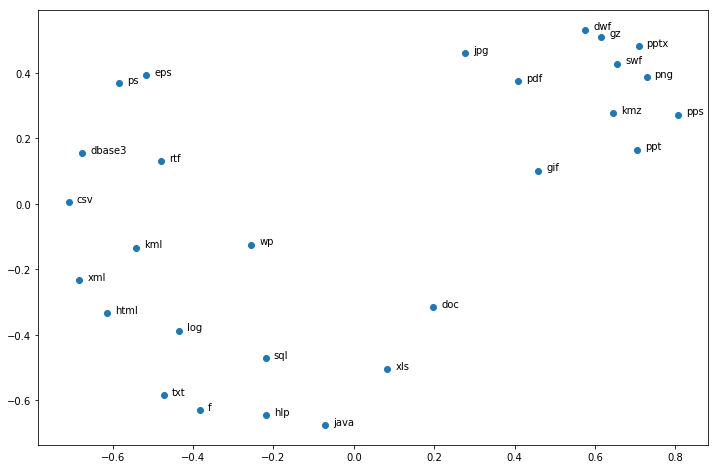

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(28):
    ax.annotate(rawset.ix_to_cat[i], (data7[i,0]+0.02, data7[i,1]))